In [18]:
import cv2
import os
import PIL

from numpy import array
import numpy as np

import tensorflow as tf

import keras.backend as K
from keras.preprocessing import image
from keras.layers import Activation, BatchNormalization, Conv2D
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.layers import Lambda, Input, add, Dense
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD, Adam, RMSprop

import matplotlib.pyplot as plt

import skimage.transform
from skimage import data, io, filters
from skimage.transform import rescale, resize

plt.switch_backend('agg')

### Data preprocessing
HR and LR images in the form of a numpy array from a given list of images.

Low resolution images are down scaled by 4.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_images():
    train_images = []
    test_images = []

    train_path = '/content/drive/My Drive/data/train/'
    test_path = '/content/drive/My Drive/data/test/'

    train_data = os.listdir(train_path)
    test_data = os.listdir(test_path)

    for sample in train_data:
        img_path = train_path + sample
        train_hr_images = cv2.imread(img_path)
        train_images.append(train_hr_images)

    for sample in test_data:
        img_path = test_path + sample
        test_hr_images = cv2.imread(img_path)
        test_images.append(test_hr_images)

    return train_images, test_images


def hr_images(images):
    images_hr = array(images)
    return images_hr


def lr_images(images_real, downscale):
    images = []
    for img in range(len(images_real)):
        images.append(
            np.array(
                PIL.Image.fromarray(images_real[img]).resize(
                    [
                        images_real[img].shape[0] // downscale,
                        images_real[img].shape[1] // downscale
                    ],
                    resample=PIL.Image.BICUBIC)))
    images_lr = array(images)
    return images_lr

In [4]:
x_train, x_test = load_images()

# for display purpose only
x_train_hr_sample = hr_images(x_train)

x_train_lr_sample = lr_images(x_train, 4)

x_test_hr_sample = hr_images(x_test)

x_test_lr_sample = lr_images(x_test, 4)

#### Function to convert cv2 BGR format to RGB for showing

In [5]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

#### Displaying sample images

50
10


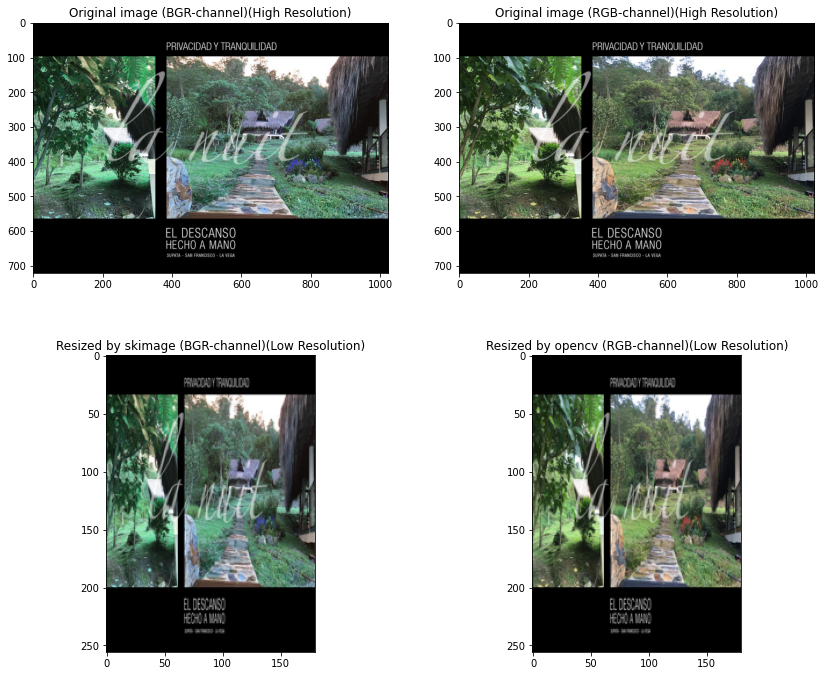

In [6]:
print(len(x_train))
print(len(x_test))

rand_num = np.random.randint(len(x_train_hr_sample))
plt.figure(figsize=(14, 12))
plt.subplot(2, 2, 1)
plt.title('Original image (BGR-channel)(High Resolution)')
plt.grid(False)
plt.imshow(x_train_hr_sample[rand_num])
plt.subplot(2, 2, 2)
plt.title('Original image (RGB-channel)(High Resolution)')
plt.grid(False)
plt.imshow(cvtRGB(x_train_hr_sample[rand_num]))
plt.subplot(2, 2, 3)
plt.title('Resized by skimage (BGR-channel)(Low Resolution)')
plt.grid(False)
plt.imshow((x_train_lr_sample[rand_num]))
plt.subplot(2, 2, 4)
plt.title('Resized by opencv (RGB-channel)(Low Resolution)')
plt.grid(False)
plt.imshow(cvtRGB(x_train_lr_sample[rand_num]))
plt.show()

### Range of HR and LR images

The range of LR input images is scaled to [0, 1]

The range of HR input images is scaled to [-1, 1]

In [7]:
'''The MSE loss was thus calculated on images of intensity range [-1, 1]. VGG feature maps were also rescaled by a factor of 1/12.75
 to obtain VGG losses of a scale that is comparable to the MSE loss.'''


#function to scale HR images to range [-1, 1]
def preprocess_HR(x):
    return (np.divide(x.astype(np.float32), 127.5) -
            np.ones_like(x, dtype=np.float32))


def deprocess_HR(input_data):
    input_data = (input_data + 1) * 127.5
    return input_data.astype(np.uint8)


#function to scale LR images to range [0, 1]
def preprocess_LR(x):
    return np.divide(x.astype(np.float), 255.)


#Unable to understand the reason behind the use of this function
def deprocess_LR(x):
    x = np.clip(x * 255, 0, 255)
    return x.astype(np.uint8)

### Loading the above functions

In [8]:
def resize_images(img):

    img_size = 192
    resized_images = []

    for i in range(len(img)):
        resized_images.append(
            np.array(
                PIL.Image.fromarray(img[i]).resize(
                    [img_size, img_size], resample=PIL.Image.BICUBIC)))

    resized_images = array(resized_images)
    return resized_images

In [9]:
x_train = hr_images(x_train)
x_train_hr_resized = resize_images(x_train)
x_train_hr = preprocess_HR(x_train_hr_resized)

x_train_lr = lr_images(x_train_hr_resized, 4)
x_train_lr = preprocess_LR(x_train_lr)

x_test = hr_images(x_test)
x_test_hr_resized = resize_images(x_test)
x_test_hr = preprocess_HR(x_test_hr_resized)

x_test_lr = lr_images(x_test_hr_resized, 4)
x_test_lr = preprocess_LR(x_test_lr)

print(x_train_hr[4].shape)
# print(x_train_hr[4])
print(x_train_lr[4].shape)
# print(x_train_lr)
print(x_test_hr[1].shape)
print(x_test_lr[1].shape)

(192, 192, 3)
(48, 48, 3)
(192, 192, 3)
(48, 48, 3)


### Show sample of images

### Generator Network
Number of Residual blocks used are 16.

Number of up-sampling blocks are 2.


In [10]:
def res_block_gen(model, kernel_size, filters, strides):

    generator = model

    model = Conv2D(filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(model)
    model = BatchNormalization(momentum=0.5)(model)
    model = PReLU(alpha_initializer="zeros",
                  alpha_regularizer=None,
                  alpha_constraint=None,
                  shared_axes=[1, 2])(model)
    model = Conv2D(filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(model)
    model = BatchNormalization(momentum=0.5)(model)

    model = add([generator, model])

    return generator


def up_sampling_block(model, kernel_size, filters, strides):

    model = Conv2D(filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(model)
    model = UpSampling2D(size=2)(model)
    model = LeakyReLU(alpha=0.2)(model)

    return model


class Generator(object):
    def __init__(self, noise_shape):
        self.noise_shape = noise_shape

    def generator(self):
        gen_input = Input(shape=self.noise_shape)

        model = Conv2D(filters=64, kernel_size=9, strides=1,
                       padding="same")(gen_input)
        model = PReLU(alpha_initializer='zeros',
                      alpha_regularizer=None,
                      alpha_constraint=None,
                      shared_axes=[1, 2])(model)

        gen_model = model

        for index in range(16):
            model = res_block_gen(model, 3, 64, 1)

        model = Conv2D(filters=64, kernel_size=3, strides=1,
                       padding="same")(model)
        model = BatchNormalization(momentum=0.5)(model)

        model = add([gen_model, model])

        for index in range(2):
            model = up_sampling_block(model, 3, 256, 1)

        model = Conv2D(filters=3, kernel_size=9, strides=1,
                       padding="same")(model)
        model = Activation('tanh')(model)

        generator_model = Model(inputs=gen_input, outputs=model)

        print(generator_model)

        return generator_model

### Discriminator Network


In [11]:
''' Discriminator is use to distinguish the HR images and back-propagate the GAN loss to train the discriminator and the generator'''


def discriminator_block(model, filters, kernel_size, strides):

    model = Conv2D(filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(model)
    model = BatchNormalization(momentum=0.5)(model)
    model = LeakyReLU(alpha=0.2)(model)

    return model


class Discriminator(object):
    def __init__(self, image_shape):
        self.image_shape = image_shape

    def discriminator(self):

        dis_input = Input(shape=self.image_shape)

        model = Conv2D(filters=64, kernel_size=3, strides=1,
                       padding="same")(dis_input)
        model = LeakyReLU(alpha=0.2)(model)

        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)

        model = Flatten()(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha=0.2)(model)

        model = Dense(1)(model)
        model = Activation('sigmoid')(model)

        discriminator_model = Model(inputs=dis_input, outputs=model)

        return discriminator_model

In [12]:
class VGG_LOSS(object):
    def __init__(self, image_shape):

        self.image_shape = image_shape

    def vgg_loss(self, y_true, y_pred):

        vgg19 = VGG19(include_top=False,
                      weights="imagenet",
                      input_shape=self.image_shape)
        vgg19.trainable = False

        for l in vgg19.layers:
            l.trainable = False

        loss_model = Model(inputs=vgg19.input,
                           outputs=vgg19.get_layer('block5_conv4').output)
        loss_model.trainable = False

        # '''vgg_loss here represents the MSE(Mean Square Error) of features extracted by a VGG-19 network. For a
        #    specific layer within VGG-19, we want their features to be matched (Minimum MSE for features)'''

        vgg_loss = K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

        return vgg_loss

### Content Loss Function

Compares the outputs of the first convolutionns of VGG.

This loss ensures the GAN model is oriented towards a deblurring task.

### Generator and Discriminator combined
Two loss used, content loss defined above and Adversarial loss(Binary cross-entropy loss)

In [13]:
def get_gan_network(discriminator, shape, generator, optimizer, vgg_loss):

    discriminator.trainable = False  #Why is the disciminator parameters not to be trained?

    gan_input = Input(shape=shape)  #Why is here this input?
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x, gan_output])
    #Compiled GAN network with VGG loss and binary crossentropy loss
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan

### Optimizer Function
Adam optimizer with *B1* = 0.9, *B2* = 0.999  and learning rate = 0.0001

In [14]:
def get_optimizer():

    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

### Function to plot the generated images

In [15]:
#     rand_nums = np.random.randint(0, 5, size = 3)
#     print(rand_nums)


def plot_generated_images(epoch,
                          generator,
                          examples=3,
                          dim=(1, 3),
                          figsize=(15, 5)):

    rand_nums = np.random.randint(0, x_test_hr.shape[0], size=examples)

    image_batch_hr = deprocess_HR(x_test_hr[rand_nums])
    image_batch_lr = x_test_lr[rand_nums]

    gen_img = generator.predict(image_batch_lr)
    generated_image = deprocess_HR(gen_img)
    image_batch_lr = deprocess_LR(image_batch_lr)

    plt.figure(figsize=figsize)

    plt.subplot(dim[0], dim[1], 1)
    plt.imshow(image_batch_lr[1], interpolation='nearest')
    plt.axis('off')

    plt.subplot(dim[0], dim[1], 2)
    plt.imshow(generated_image[1], interpolation='nearest')
    plt.axis('off')

    plt.subplot(dim[0], dim[1], 3)
    plt.imshow(image_batch_hr[1], interpolation='nearest')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/data/output/gan_generated_image_epoch_%d.png' % epoch)

### Train Function

In [16]:
np.random.seed(10)
image_shape = (192, 192, 3)


# higher image shape causes resource exhaustion so the image shape is reduced here but higher quality images must be used
def train(epochs, batch_size):

    downscale_factor = 4

    loss = VGG_LOSS(image_shape)

    batch_count = int(x_train_hr.shape[0] / batch_size)
    shape = (image_shape[0] // downscale_factor,
             image_shape[1] // downscale_factor, image_shape[2])

    generator = Generator(shape).generator()
    
    discriminator = Discriminator(image_shape).discriminator()

    # print(generator.summary())
    # print(discriminator.summary())
    # print(loss.summary())
    adam = get_optimizer()
    generator.compile(loss=loss.vgg_loss, optimizer=adam)
    discriminator.compile(loss='binary_crossentropy', optimizer=adam)

    gan = get_gan_network(discriminator, shape, generator, adam, loss.vgg_loss)
    
    for e in range(1, epochs + 1):
        print('-' * 15, 'Epoch %d' % e, '-' * 15)

        for _ in range(batch_count):
            rand_nums = np.random.randint(0,
                                          x_train_hr.shape[0],
                                          size=batch_size)

            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]
            generated_images_sr = generator.predict(image_batch_lr)

            real_data_Y = np.ones(
                batch_size) - np.random.random_sample(batch_size) * 0.2
            fake_data_Y = np.random.random_sample(batch_size) * 0.2

            discriminator.trainable = True

            d_loss_real = discriminator.train_on_batch(image_batch_hr,
                                                       real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr,
                                                       fake_data_Y)

            gan_Y = np.ones(
                batch_size) - np.random.random_sample(batch_size) * 0.2
            discriminator.trainable = False

            loss_gan = gan.train_on_batch(image_batch_lr,
                                          [image_batch_hr, gan_Y])

            print("Loss HR, Loss LR, Loss GAN")
            print(d_loss_real, d_loss_fake, loss_gan)

            if (e == 1 or e % 5 == 0):
                plot_generated_images(e, generator)
            if (e % 300 == 0):
                generator.save('/content/drive/My Drive/data/output/gen_model%d.h5' % e)
                discriminator.save('/content/drive/My Drive/data/output/dis_model%d.h5' % e)
                gan.save('/content/drive/My Drive/data/output/gan_model%d.h5' % e)

--------------- Epoch 1 ---------------
Loss HR, Loss LR, Loss GAN
0.97504497 27.385841 [0.0010996073, 6.8168355e-08, 1.099539]


FailedPreconditionError: ignored

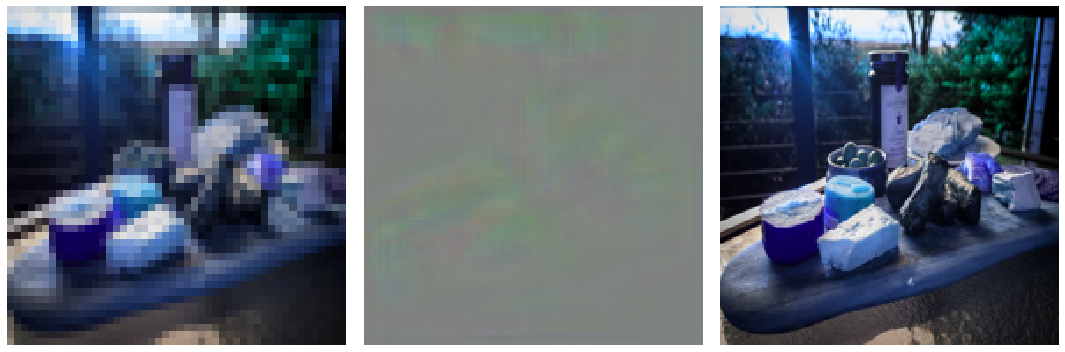

In [19]:
train(20000, 4)